# 0. Setup

## 0.1. Libraries

In [1]:
# Utilities
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Deep learning
import torch
from torch import nn, utils
from torchmetrics import classification

# Custom library
from library import nn_model, utilities, visualizations, preprocessing

# Device
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
device = torch.device(device)
print(f'Using device: {device}')

# Utilities
# classes = {0:'non-building', 255:'building'}
seed = 42
utilities.set_seed(seed)

Using device: cuda
Seed set to 42 for NumPy, Torch and Random for reproducibility.


## 0.2. Setting the path to the training data

We set the path to the tiles that have been created in the preprocessing notebook, `3_preprocessing.ipynb`.

In [2]:
base_input_dir = '/media/pablo/Shared files/data/'  # Adjust this path to your data directory containing the labelled dataset
input_labelled_dir = os.path.join(base_input_dir, 'Satellite_burned_area_dataset')  # Path to the original labelled dataset
tile_dir = os.path.join(base_input_dir, 'tiled_labelled_dataset')  # Path to the tiled dataset
sentinel_type = 2  # Sentinel-2 data

Additionally, within the paper, the authors of the dataset provide additional metadata and a suggestion for the organization of the folds for training/validation (see the `folds` column): "*[d]ata were split into 7 folds according to geographical location, such that data belonging to the same fold maintains similar morphological features.*"

This will be taken into account for training-validation.

In [3]:
df_folds = pd.read_csv(os.path.join(input_labelled_dir, 'satellite_data.csv'))

print("Number of rows (different fires) in the DataFrame:", len(df_folds))
print("Columns in the DataFrame:", df_folds.columns.tolist())
print("Number of unique folds considered by the authors:", df_folds['fold'].nunique())

df_folds.head()

Number of rows (different fires) in the DataFrame: 73
Columns in the DataFrame: ['folder', 'top_left_long', 'top_left_lat', 'bottom_right_long', 'bottom_right_lat', 'activation_date', 'suggested_pre_date_from', 'suggested_pre_date_to', 'suggested_post_date_from', 'suggested_post_date_to', 'download_period_start', 'download_period_end', 'height', 'width', 'pre_date', 'post_date', 'situation_as_of', 'longitude', 'latitude', 'fold']
Number of unique folds considered by the authors: 7


,folder,top_left_long,top_left_lat,bottom_right_long,bottom_right_lat,activation_date,suggested_pre_date_from,suggested_pre_date_to,suggested_post_date_from,suggested_post_date_to,download_period_start,download_period_end,height,width,pre_date,post_date,situation_as_of,longitude,latitude,fold
0,EMSR214_05LELAVANDOU_02GRADING_MAP_v1_vector,6.104806,43.342188,6.452223,43.065393,24/07/2017,2017-06-13,2017-07-14,2017-07-24,2017-08-24,24/06/2017,24/08/2017,522,512,14/07/2017 10:30,18/08/2017 10:34,28/07/2017,6.278515,43.203790,purple
1,EMSR207_04AVELAR_02GRADING_MAP_v2_vector,-8.499468,40.026117,-8.307374,39.904662,17/06/2017,2017-05-07,2017-06-07,2017-06-17,2017-07-18,17/05/2017,17/07/2017,512,615,NaN,NaN,20/06/2017,-8.403421,39.965389,coral
2,EMSR207_08CERNACHEDOBONJARDIM_02GRADING_MAP_v2...,-8.307667,39.904662,-8.116087,39.783514,17/06/2017,2017-05-07,2017-06-07,2017-06-17,2017-07-18,17/05/2017,17/07/2017,512,613,NaN,NaN,20/06/2017,-8.211877,39.844088,coral
3,EMSR209_01MOGUER_02GRADING_MAP_v2_vector,-6.847640,37.291966,-6.702477,37.166775,24/06/2017,2017-05-14,2017-06-14,2017-06-24,2017-07-25,24/05/2017,24/07/2017,579,512,01/06/2017 11:12,01/07/2017 11:17,NaN,-6.775058,37.229371,pink
4,EMSR298_02HAMMARSTRAND_02GRADING_MAP_v1_vector,16.361547,63.140440,16.447381,63.099674,16/07/2018,2018-06-05,2018-07-06,2018-07-16,2018-08-16,16/06/2018,16/08/2018,561,512,14/07/2018 10:30,27/07/2018 10:40,NaN,16.404464,63.120057,grey


## 0.3. Notebook description

We train a multi-class segmentation model that assesses wildfire severity using satellite images **from Sentinel-2 L2A** (the "natural-looking" images). Additional steps applied during training:
- Randomly shuffle the tiles (done at the training stage).
- Apply data augmentation techniques to improve the robustness of the model. The authors implement the following transformations (we will do similar but different ones, this is just as reference): "*We applied the following transformations: rotation (up to 50° on both sides), shear (up to 20°), horizontal flip, and vertical flip, all of them with a probability of 50%.*"
- If computationally feasible, we will do cross-fold validation. Otherwise, we will just divide the data statically into training, validation and test. The authors use "*a 7-fold cross-validation approach [...]: 5 folds were used as a training set, 1 fold as a validation set, and 1 fold as a test set.*"
- Adjust the training hyperparameters: "*16GB. The training was performed using 50 epochs, the Adam optimizer with a learning rate of 0.0001 with no weight decay. The Dice loss was used for training. [...] We implemented an early stopping mechanism with patience of 5 epochs and tolerance of 0.01 on validation loss. The final evaluation is performed on the test set.*"

> The final goal is to train a model that estimates the severity of a wildfire using post-wildfire (1 month after) imagery, and then to run inference with the satellite images from wildfires in Catalunya in the last decade. Severity estimation will be done at the pixel level.

We are going to use the U-Net architecture:

![U-Net model](unet_diagram.jpg)

# 1. Preparing the data

## 1.1. Getting the image and masks paths

In [4]:
# Get all of the folders within the tiles directory
fire_folders = sorted([f for f in os.listdir(tile_dir) if os.path.isdir(os.path.join(tile_dir, f))])
# Print the first 5 folders
print("First 5 fire folders:")
print(fire_folders[:5])
# Print the total number of fire folders
print("Total number of fire folders:", len(fire_folders))

# Get the paths for the images and the labels
image_paths = []
label_paths = []
for fire_folder in fire_folders:
    print(f"Fire folder: {fire_folder}")
    images_path = os.path.join(tile_dir, fire_folder, 'images')
    labels_path = os.path.join(tile_dir, fire_folder, 'masks')
    if os.path.exists(images_path):
        image_paths.append(sorted([os.path.join(images_path, img) for img in os.listdir(images_path) if img.startswith(f'sentinel{sentinel_type}') and img.endswith('.tiff')]))
    else:
        print(f"Images path does not exist: {images_path}")
    if os.path.exists(labels_path):
        label_paths.append(sorted([os.path.join(labels_path, lbl) for lbl in os.listdir(labels_path) if lbl.endswith('.tiff')]))
    else:
        print(f"Labels path does not exist: {labels_path}")
# Print the first 5 image paths
print(f"First 5 image and label paths of the fire folder: {fire_folders[0]}")
print(image_paths[0][:5])  # The result is a list of lists, where each sublist contains the paths of images for a specific fire folder
print(label_paths[0][:5])  # The result is a list of lists, where each sublist contains the paths of labels for a specific fire folder

# Print the total number of lists in image_paths and label_paths (should be equal to the number of fire folders)
print("Total number of fire folders in image_paths:", len(image_paths))
print("Total number of fire folders in label_paths:", len(label_paths))

First 5 fire folders:
['EMSR207_01MIRANDADOCORVO_02GRADING_MAP_v2_vector', 'EMSR207_02LOUSA_02GRADING_MAP_v2_vector', 'EMSR207_03PAMPILHOSADASERRA_02GRADING_MAP_v2_vector', 'EMSR207_04AVELAR_02GRADING_MAP_v2_vector', 'EMSR207_05PEDROGAOGRANDE_02GRADING_MAP_v2_vector']
Total number of fire folders: 73
Fire folder: EMSR207_01MIRANDADOCORVO_02GRADING_MAP_v2_vector
Fire folder: EMSR207_02LOUSA_02GRADING_MAP_v2_vector
Fire folder: EMSR207_03PAMPILHOSADASERRA_02GRADING_MAP_v2_vector
Fire folder: EMSR207_04AVELAR_02GRADING_MAP_v2_vector
Fire folder: EMSR207_05PEDROGAOGRANDE_02GRADING_MAP_v2_vector
Fire folder: EMSR207_06MADEIRA_02GRADING_MAP_v2_vector
Fire folder: EMSR207_07ALVAIAZERE_02GRADING_MAP_v2_vector
Fire folder: EMSR207_08CERNACHEDOBONJARDIM_02GRADING_MAP_v2_vector
Fire folder: EMSR207_10ORVALHO_02GRADING_MAP_v2_vector
Fire folder: EMSR209_01MOGUER_02GRADING_MAP_v2_vector
Fire folder: EMSR209_02MAZAGON_02GRADING_MAP_v2_vector
Fire folder: EMSR209_03LOSCABEZUDOS_02GRADING_MAP_v1_vecto

## 1.2. Loading the image and masks into tensors

We load the images and labels as `torch.Tensor` of dimensions $n \times d \times h \times w$, where:
- $n$: number of images (tiles)/masks.
- $d$: number of channels for the images/masks.
- $h$: height of the images and of the masks. Both are of 256 height, as designed in `3_preprocessing`.
- $w$: width of the images and of the masks. Both are of 256 height, as designed in `3_preprocessing`.

We normalize each channel to $N[0,1]$ and set the data type as `torch.float16` (instead of `float32` for greater memory efficiency). Why we normalize image channels:

1. **Gradient stability**: Different channels may have vastly different value ranges, leading to unstable gradients
2. **Training speed**: Normalized inputs help the optimizer converge faster
3. **Weight initialization**: Most weight initialization schemes assume normalized inputs
4. **Activation functions**: Work optimally with inputs in specific ranges

In [32]:
# Flatten the lists of image and label paths
images_flat = [item for sublist in image_paths for item in sublist]
labels_flat = [item for sublist in label_paths for item in sublist]

# Set to float16 for memory efficiency

# Read images and labels and stack them into a single tensor
images = torch.stack([utilities.read_tiff_to_torch(file_path = image, dtype=torch.float16, normalize=True, normalization_method='per_channel') for image in images_flat])
labels_raw = torch.stack([utilities.read_tiff_to_torch(file_path = label, dtype = torch.float16, normalize=False) for label in labels_flat])  # Masks are encoded in 0-255 range according to the paper

# Map the raw label values (0, 64, 128, 191, 255) to class indices (0, 1, 2, 3, 4)
# Assumes labels are encoded as: 0=unburned, 64=low, 128=moderate-low, 191=moderate-high, 255=high
def map_labels_to_classes(labels_tensor):
    """
    Map pixel values to class indices for 5-class segmentation
    0 -> 0 (unburned)
    64 -> 1 (low severity) 
    128 -> 2 (moderate-low severity)
    191 -> 3 (moderate-high severity)
    255 -> 4 (high severity)
    """
    labels_mapped = torch.zeros_like(labels_tensor, dtype=torch.long)
    
    # Create masks for each class value
    labels_mapped[labels_tensor == 0] = 0
    labels_mapped[labels_tensor == 64] = 1
    labels_mapped[labels_tensor == 128] = 2
    labels_mapped[labels_tensor == 191] = 3
    labels_mapped[labels_tensor == 255] = 4
    
    return labels_mapped

# Apply the mapping
labels = map_labels_to_classes(labels_raw)

Now, let's check the array dimensions and display several image–label pairs to ensure that they are correctly aligned.

In [33]:
print('Size of the image tensor:', images.size())
print('Size of the label tensor:', labels.size())

# Check if the number of images and labels are equal
if images.size(0) != labels.size(0):
    raise ValueError('Number of images and labels do not match!')

Size of the image tensor: torch.Size([3374, 13, 256, 256])
Size of the label tensor: torch.Size([3374, 1, 256, 256])


i.e., in this case:

- $n$: we have 3,374 images and masks.
- $d$: number of channels for the images/masks. The images have 13 dimensions (bands B01-B12 from Sentinel-2 L2A, https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Data/S2L2A.html#available-bands-and-data).
- $h$: height of the images and of the masks. Both are of 256 height, as designed in `3_preprocessing`.
- $w$: width of the images and of the masks. Both are of 256 height, as designed in `3_preprocessing`.

## 1.3. Checking the alignment: displaying several image-label pairs

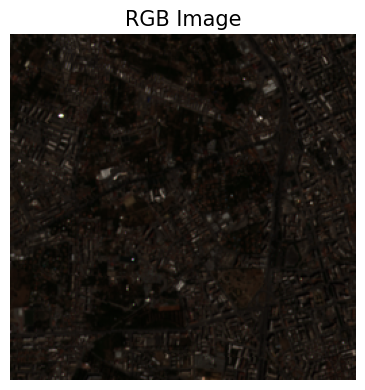

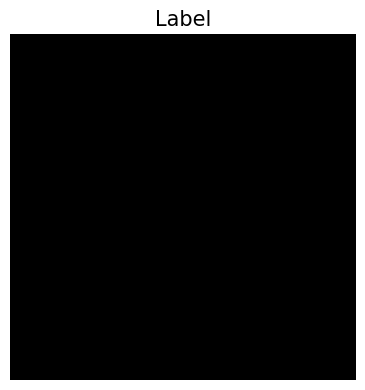

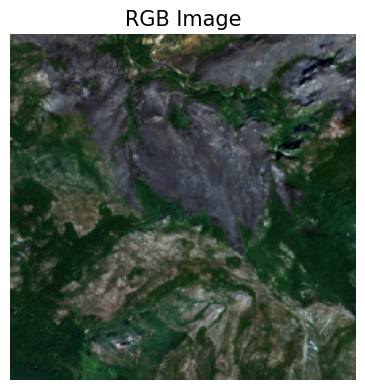

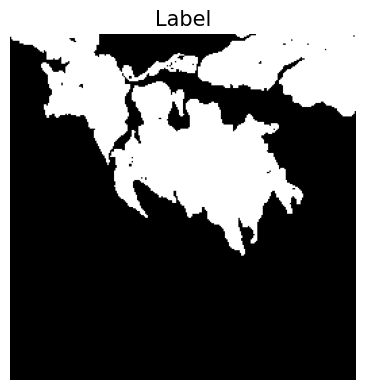

In [59]:
# Displays random images, labels and images
for i in torch.randint(0, len(images), (2,)):
  visualizations.display_image(image = images[i], title = 'RGB Image', rgb_bands=(3,2,1))  # RGB bands in Sentinel-2 are 3 (B04), 2 (B03), and 1 (B02)
  visualizations.display_image(image = labels[i], title = 'Label')

Note that, in this case, the brighter the label in the mask, the higher the severity of the fire (white if maximum severity). Fires of less severity are darker. 

## 1.4. Formatting the data as a `TensorDataset`

Useful documentation: [`torch.utils.data`](https://pytorch.org/docs/stable/data.html)

In [26]:
# Format the data as a TensorDataset
dataset = utils.data.TensorDataset(images, labels)  # Create a TensorDataset from the image and label tensors
print(len(dataset))

3374


## 1.5. Splitting data into train, validation and test

We split into 70% training data, 15% validation and 15% test.

In [27]:
# Split the dataset into training, validation and test sets
train_dataset, val_dataset, test_dataset = utils.data.random_split(dataset, [0.7, 0.15, 0.15], generator=torch.Generator().manual_seed(42))

# Set batch size
batch_size = 64

# Set number of physical CPU cores (as int) to use for data loading
num_workers = os.cpu_count() // 2 if os.cpu_count() is not None else 0

# Create DataLoaders for each dataset
train_loader = utils.data.DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True,  # Shuffle the training data to prevent learning order bias, overfitting and improve generalization
    num_workers=num_workers,  # Use multiple workers for faster data loading
    pin_memory=True if device == 'cuda' else False,  # Pin memory for faster data transfer to GPU
)

val_loader = utils.data.DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    shuffle=False,  # Keep validation data in the same order for consistent evaluation
    num_workers=num_workers,  # Use multiple workers for faster data loading
    pin_memory=True if device == 'cuda' else False,  # Pin memory for faster data transfer to GPU
)

test_loader = utils.data.DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False,  # Keep test data in the same order for consistent evaluation
    num_workers=num_workers,  # Use multiple workers for faster data loading
    pin_memory=True if device == 'cuda' else False,  # Pin memory for faster data transfer to GPU
)

# 2. Training and validation

## 2.1. Neural Network Architecture

![U-Net model](unet_diagram.jpg)

The basic structure of this network is the following:

1. **Input**: a tensor of shape $(N, D, H, W)$.
2. **Encode** down through five levels, doubling channels each time and halving spatial dimensions.
3. **Bottleneck**: deepest features at 128 channels.
4. **Decode** back up, halving channels and doubling spatial dimensions, while concatenating corresponding encoder features to preserve fine details.
5. **Output**: apply a 1×1 convolution → Sigmoid to produce a mask of shape $(N, 1, H, W)$ with values in (0,1).

All of the classes below initialize the parameters at each layer with `__init__` and then implement a `forward` method that defines the forward pass of the neural network, which "takes the input data and passes it through the layers of the network to produce the output. This method is executed whenever the model is called to make a prediction or to compute the loss during training" ([reference](https://discuss.pytorch.org/t/what-is-the-difference-init-and-forward-in-a-network-model/173907)).

### The double convolution

The two convolutional layers are included everywhere in the network, from the encoding to the decoding. For more information, check `DoubleConv` in the library `library`.

Useful sources:
- [`Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d) - convolutional layer
- [`BatchNorm2d`](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html#torch.nn.BatchNorm2d) - normalization layer
- [`ReLU`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU) - non-linear activation function

### The encoder module (`Down`)

The class below represents one encoding step. For more information, check `Down` in the library `library`.

Useful sources:
- [`MaxPool2d`](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d) - pooling layer

### The decoder module (`Up`)

This class represents one decoding step. It performs upsampling and concatenation with skip connection. For more information, check `Up` in the library `library`.

This class:

1. Upsamples via either bilinear interpolation or a learnable transposed convolution. See [`nn.Upsample`](https://pytorch.org/docs/stable/generated/torch.nn.Upsample.html#torch.nn.Upsample)
2. Pads if the resulting feature-map is off by 1 pixel in height/width. See [`nn.functional.pad`](https://pytorch.org/docs/stable/generated/torch.nn.functional.pad.html#torch.nn.functional.pad)
3. Concatenates with the corresponding encoder feature-map along the channel dimension (the “skip connection”). See [`torch.cat`](https://pytorch.org/docs/stable/generated/torch.cat.html)
4. Uses `DoubleConv` to fuse and refine these combined features.

### Final 1 $\times$ 1 convolution

This convolution reduces the channels from whatever the last decoder output is (in the diagram, 8) down to the desired number of classes (1 for binary mask, as in this case - 0 for no building and 1 for building). For more information, check `OutConv` in the library `library`.

### Putting all together in `UNet`

This class uses the constructions made above, and replicates the structure of the neural network in the diagram. For more information, check `UNet` in the library `library`.

Note that the output layer returns the logits, not probabilities, for compatibility with the loss function.

## 2.2. Training setup

### Model initialization

In [31]:
# Set the parameters for the U-Net model
n_channels = images.size()[1]  # Number of input channels (RGB image)
n_classes = 5  # Number of output channels (5 classes: 0: not burned, 1-4: burned area with different severity levels, from lower to higher severity)
base_filters = 8  # Number of filters in the first layer (check diagram)
dropout_p = 0.1  # Dropout probability for regularization
bilinear = False  # Use bilinear interpolation for upsampling (True) or transposed convolution (False)

# Initialize the model
model = nn_model.UNet(
    n_channels=n_channels,
    n_classes=n_classes, 
    base_filters=base_filters,
    dropout_p=dropout_p,
    bilinear=bilinear
)
model = model.to(device)  # Move the model to the specified device (GPU or CPU)
print(model)

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(13, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Dropout2d(p=0.1, inplace=False)
    )
  )
  (down1): Down(
    (pool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1)

### Loss function (addresses class imbalance)

### Optimization algorithm